In [7]:
!pip install PyDrive
!pip install Keras==2.3.1

# Load Dataset

### Acceso a Drive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Move dataset zip from Drive and unzip it

In [0]:
download = drive.CreateFile({'id': '1YYWsgUMz2iJk16zK8lszbtAUHaBp1LAY'})
download.GetContentFile('DOWNLOAD.tar')

In [12]:
!unzip DOWNLOAD.tar

Output hidden; open in https://colab.research.google.com to view.

In [13]:
os.listdir()

['.config',
 'list_eval_partition.csv',
 'list_attr_celeba.csv',
 'img_align_celeba',
 'list_bbox_celeba.csv',
 'list_landmarks_align_celeba.csv',
 'DOWNLOAD.tar',
 'adc.json',
 'sample_data']

# Neural Network

In [0]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn


In [15]:
from __future__ import print_function
import keras
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Constants

In [0]:
# Constants

#paths
ROOT_IMG = 'img_align_celeba/img_align_celeba/'
DATASET = 'list_attr_celeba.csv'
ROOT_MODELS = 'Models/'

#img size
IMG_ROWS = 218
IMG_COLS = 178
IMG_COLORS = 3

#Num images to use
#202599
IMG_NUM=202500

# Train-Test distribution
TRAIN_RATIO=0.2
RANDOM_STATE=42

# fit parameters
BATCH_SIZE = 100
EPOCHS = 5

### Attributes

**Sex**:        'Male'\
**Hair color**: 'Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair'\
**Hair Style**: 'Bald','Straight_Hair','Wavy_Hair','Bangs','Sideburns','Receding_Hairline'\
**Age**:        'Young'\
**Beard**:      '5_o_Clock_Shadow','Goatee','No_Beard','Mustache'\
**Accesories**: 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie',   'Eyeglasses', 'Heavy_Makeup'\
**Mouth**:      'Mouth_Slightly_Open', 'Big_Lips'\
**Eyes**:       'Arched_Eyebrows', 'Bags_Under_Eyes', 'Bushy_Eyebrows', 'Narrow_Eyes'\
**Nose**:       'Big_Nose', 'Pointy_Nose'\
**Cheeks**:     'Rosy_Cheeks' ,'High_Cheekbones'\
**Others**:     'Attractive', 'Chubby', 'Double_Chin', 'Oval_Face', 'Pale_Skin', 'Smiling', 'Blurry'


In [0]:
COLUMNS=['image_id',
         'Male',
         'Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair',
         '5_o_Clock_Shadow','Goatee','No_Beard','Mustache',
         'Bald','Straight_Hair','Wavy_Hair','Bangs','Sideburns','Receding_Hairline',
         'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie', 'Eyeglasses', 'Heavy_Makeup'
         ]

In [0]:
# Shape ofe the images
input_shape = ( IMG_ROWS, IMG_COLS, IMG_COLORS)
# Number of labels
num_classes = len(COLUMNS)-1

In [19]:
#NN topology
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train-Test distribution

In [0]:

df=pd.read_csv(DATASET)
df=df[0:IMG_NUM]
df=df[COLUMNS]
df=df.replace(-1,0)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
                df.image_id, df.drop(columns=['image_id']), test_size=TRAIN_RATIO, random_state=RANDOM_STATE)

### Generator

In [0]:
# generator to feed the fit
def generator(data,target,bs,rootImg,mode='train'):

    faces=[]
    attributes=[]
    count=0
    while True:
        faces.append(cv2.imread(rootImg+data.iloc[count]))
        attributes.append(target.iloc[count].values)
        count+=1
        if len(attributes)==bs:
            faces=np.array(faces)
            attributes=np.array(attributes)
            if mode == "eval":
              yield faces
            else:
              yield faces, attributes
            faces=[]
            attributes=[]
        if count==data.shape[0]:
            if mode == "eval":
                break
            else:
                count=0

In [0]:
# Save the model at the end of every epoch if val_accuracy is better 
filepath='Checkpoint_{epoch:02d}_{val_accuracy:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### Fit model

In [24]:
#Fit model
trainGen=generator(X_train,y_train,BATCH_SIZE*(1-TRAIN_RATIO),ROOT_IMG)
testGen=generator(X_test,y_test,BATCH_SIZE*TRAIN_RATIO,ROOT_IMG)

H = model.fit_generator(
    trainGen,
    steps_per_epoch=IMG_NUM*(1-TRAIN_RATIO)//BATCH_SIZE,
    validation_data=testGen,
    validation_steps=IMG_NUM*TRAIN_RATIO//BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list)


Epoch 1/5
1620/1620 [==============================] - 817s 505ms/step - loss: 1.6175 - accuracy: 0.8647 - val_loss: 0.2568 - val_accuracy: 0.8883

Epoch 00001: val_accuracy improved from -inf to 0.88827, saving model to Checkpoint_01_0.89
Epoch 2/5
1620/1620 [==============================] - 814s 502ms/step - loss: 0.2807 - accuracy: 0.8842 - val_loss: 0.2413 - val_accuracy: 0.8948

Epoch 00002: val_accuracy improved from 0.88827 to 0.89479, saving model to Checkpoint_02_0.89
Epoch 3/5
1620/1620 [==============================] - 816s 504ms/step - loss: 0.2634 - accuracy: 0.8890 - val_loss: 0.3063 - val_accuracy: 0.8974

Epoch 00003: val_accuracy improved from 0.89479 to 0.89744, saving model to Checkpoint_03_0.90
Epoch 4/5
1620/1620 [==============================] - 814s 503ms/step - loss: 0.2522 - accuracy: 0.8926 - val_loss: 0.2241 - val_accuracy: 0.9015

Epoch 00004: val_accuracy improved from 0.89744 to 0.90148, saving model to Checkpoint_04_0.90
Epoch 5/5
1620/1620 [=========

In [0]:
moment=time.localtime()
name='Model_{}_{}-{}-{}.h5'.format(model.history.history["val_accuracy"][-1],moment[2],moment[3],moment[4])
model.save(name)

In [0]:
import json

model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name+'.h5')

In [32]:
os.listdir()

['.config',
 'Model_0.9033779501914978_15-17-27.h5.json',
 'list_eval_partition.csv',
 'Model_0.9033779501914978_15-17-27.h5.h5',
 'Checkpoint_02_0.89',
 'Checkpoint_04_0.90',
 'list_attr_celeba.csv',
 'Model_0.9033779501914978_15-17-27.h5',
 'img_align_celeba',
 'Checkpoint_01_0.89',
 'list_bbox_celeba.csv',
 'list_landmarks_align_celeba.csv',
 'DOWNLOAD.tar',
 'Checkpoint_03_0.90',
 'adc.json',
 'Checkpoint_05_0.90',
 'sample_data']

In [0]:

upload = drive.CreateFile({'title': name+'.json'})
upload.SetContentFile(name+'.json')
upload.Upload()

In [0]:
upload = drive.CreateFile({'title': name+'.h5'})
upload.SetContentFile(name+'.h5')
upload.Upload()

In [30]:
# re-initialize our testing data generator, this time for evaluating
testGen=generator(X_test,y_test,BATCH_SIZE,ROOT_IMG,mode="eval")
 
# make predictions on the testing images, finding the index of the
# label with the corresponding largest predicted probability
predIdxs = model.predict_generator(testGen,
            steps=IMG_NUM*TRAIN_RATIO//BATCH_SIZE,verbose=1)

405/405 [==============================] - 75s 185ms/step


In [36]:
predIdxs

array([[2.4789572e-03, 1.0303661e-01, 2.6741803e-02, ..., 1.4960766e-05,
        3.2782555e-07, 6.6746926e-01],
       [5.3360760e-03, 2.7505457e-03, 4.5137972e-01, ..., 3.6656857e-05,
        3.2156706e-05, 5.8868027e-01],
       [9.9566531e-01, 2.7944782e-01, 2.0200312e-03, ..., 2.5247294e-01,
        1.8869281e-02, 2.4080276e-04],
       ...,
       [9.9900675e-01, 7.4232519e-03, 4.8534572e-03, ..., 6.0188472e-01,
        5.4057449e-01, 8.3148479e-06],
       [4.9330890e-03, 7.8147322e-02, 2.0883623e-01, ..., 3.3548474e-04,
        3.1042099e-04, 5.3732562e-01],
       [2.1240115e-04, 1.2466520e-02, 3.9582354e-01, ..., 2.6822090e-06,
        4.4882298e-05, 7.3447585e-01]], dtype=float32)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def accuracy(y_test,y_pred,labels):
    for i,attribute in enumerate(labels):
        cm=confusion_matrix(y_test.iloc[:,i],y_pred[:,i])
        norm_cm=cm/len(list(y_test.iloc[:,0]))
        print('\n\n====')
        print(attribute+' score: '+ str(accuracy_score(list(y_test.iloc[:,i]),list(y_pred[:,i]))))
        print(norm_cm)
        
predictions=[]
aux=[]
for pred in predIdxs:
    for attPred in pred:
        aux.append(round(attPred))
    predictions.append(aux)
    aux=[]
    
predictions=np.array(predictions)
        
accuracy(y_test,predictions,COLUMNS[1:])



====
Male score: 0.9411358024691358
[[0.55748148 0.02851852]
 [0.03034568 0.38365432]]


====
Black_Hair score: 0.8596296296296296
[[0.71804938 0.04098765]
 [0.09938272 0.14158025]]


====
Blond_Hair score: 0.9153827160493827
[[0.83538272 0.01790123]
 [0.06671605 0.08      ]]


====
Brown_Hair score: 0.8168888888888889
[[0.7765679  0.01940741]
 [0.1637037  0.04032099]]


====
Gray_Hair score: 0.9637777777777777
[[0.95609877 0.00269136]
 [0.03353086 0.00767901]]


====
5_o_Clock_Shadow score: 0.9007407407407407
[[0.87995062 0.00938272]
 [0.08987654 0.02079012]]


====
Goatee score: 0.9482469135802469
[[0.93079012 0.00587654]
 [0.04587654 0.01745679]]


====
No_Beard score: 0.9131111111111111
[[0.09676543 0.06762963]
 [0.01925926 0.81634568]]


====
Mustache score: 0.9582962962962963
[[0.9562716  0.00158025]
 [0.04012346 0.00202469]]


====
Bald score: 0.9782716049382716
[[0.97587654 0.00217284]
 [0.01955556 0.00239506]]


====
Straight_Hair score: 0.7947901234567901
[[0.77738272 0.013

Attributes : ['Male', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair', '5_o_Clock_Shadow', 'Goatee', 'No_Beard', 'Mustache', 'Bald', 'Straight_Hair', 'Wavy_Hair', 'Bangs', 'Sideburns', 'Receding_Hairline', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie', 'Eyeglasses', 'Heavy_Makeup']
Real: [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Prediction: [3.5107136e-05, 0.05938956, 0.072222054, 0.4485834, 5.5998564e-05, 1.0430813e-06, 0.0, 0.99999964, 0.0, 0.0, 0.24651712, 0.47601873, 0.010287404, 0.0, 0.01706341, 0.0025397837, 0.9281014, 0.23232591, 0.19284618, 1.1920929e-07, 9.802999e-07, 0.81931514]


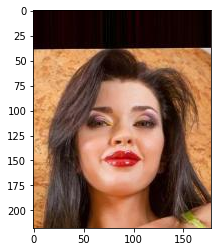

In [42]:
df_test=pd.read_csv(DATASET)
df_test=df_test[COLUMNS]
df_test=df_test.replace(-1,0)

num=78
img=cv2.imread(ROOT_IMG+'{0:06d}.jpg'.format(num))
prueba=np.array([img])
attr=np.array(df_test.iloc[num-1][1:].values)

pred = model.predict(prueba)
print('Attributes :',list(df.columns[1:]))
print('Real:',attr)
pred=[x for x in pred[0]]
print('Prediction:',pred)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

     |████████████████████████████████| 378kB 3.3MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
IMG_NUM*TRAIN_RATIO//BATCH_SIZE

0.0